<h1 style = 'text-align: center; > Can Tweeter Data Predict Election Results? </h1>

<h1 style = 'text-align: center;'> Can Twitter Data Predict Election Outcome? </h1>

#### **Introduction**

In the recent past, Twitter, like most other social media, has been a significant platform for disseminating information and shaping public opinion. When it comes to politics, especially in the US, Twitter's influence is unparalleled. Almost one-third of tweets from US adults are political, and this engagement soars during every election. Twitter data is undoubtedly an excellent reflection of public sentiment during major political events. Therefore, there is a growing interest among researchers in analyzing and interpreting Twitter data using data tools. 

This research aims to establish a connection between public sentiments and each state's election outcome using 1.72 million US election tweets collected between 2nd October and 20th November of the Year 2020, which is available on Kaggle and owned by Manch Hui. We conduct our sentiment analysis using Natural Language Processing, which uses artificial intelligence to provide a nuanced assessment of the writer's sentiment from a text. 

The US 2020 election tweets data consists of two individual data sets of tweets categorized for the two candidates - Donald Trump and Joe Biden using Hashtags. As our goal is to predict the ultimate election outcome of battleground states, we will also be merging our data with the actual election data that has the election vote counts and results by county and state. It is also collected from Kaggle. 

In this research, the outcome variable is the actual election results of each state, and the explanatory variables include the Tweet, sentiment scores of each Tweet, and the state and country of location tweeted from. We will compare the mean sentiment scores of the tweets regarding both the candidates respectively and the election outcome for each state. 





#### **Data Cleaning/Loading**

In [283]:
pip install textblob

Note: you may need to restart the kernel to use updated packages.


In [284]:
#Importing Relevant Packages 

import pandas as pd
import random
import numpy as np
from IPython.display import display
import matplotlib.pyplot as plt
import re
from matplotlib.ticker import StrMethodFormatter


from textblob import TextBlob


In [285]:
#Reading all the data relevant to my research Question 

trump_data = pd.read_csv("hashtag_donaldtrump.csv",lineterminator='\n')
biden_data = pd.read_csv("hashtag_joebiden.csv",lineterminator='\n')
election_results = pd.read_csv("president_county_candidate.csv")
trump_data = pd.DataFrame(trump_data)
biden_data = pd.DataFrame(biden_data)
total_vote_data = pd.read_csv("president_state.csv")
total_vote_data =  pd.DataFrame(total_vote_data)

It will be difficult to work with two different data sets simulataneously, so we concatenate them into a single data frame. We will also drop columns that we do not need for our analysis. 

In [287]:
#Concatenating into a single data frame

trump_data["candidate"] = "Donald Trump"
biden_data["candidate"] = "Joe Biden"
df = pd.concat([trump_data, biden_data])


In [288]:
#Removing irrelevant columns

df = df.drop( ['tweet_id','user_join_date','user_followers_count', 'likes','retweet_count','source','user_id','user_name','user_screen_name','user_description','user_location','lat','long','city','continent','state_code'], axis=1)

Since we will be using our tweet data to predict the election outcome, so we only need the pre-election tweets. By using the created_at column, we will isolate all the tweets that were made before the election. 

In [289]:
#Keeping observations from relevant time frame

df = df.loc[(df['created_at'] >= '2020-10-15 00:00:02') & (df['created_at'] < '2020-11-02 23:59:59')]

In [290]:
#Looking at the count of missing values in our data set

df.isna().sum()

created_at           0
tweet                0
country         390006
state           480289
collected_at         0
candidate            0
dtype: int64

Our research aims to predict the electoral vote counts of each state. So, we limit our analysis to the United States of America and eliminate all the observations of other countries. We can see that our data frame has many missing values for both country and state. So first, we make sure to get rid of all the observations that have the missing variable "country." We also make sure all of our observations have the variable "state," so we remove all the observations that have missing values for the variable "state". Finally, we keep all the observations pertaining to the US. 

In [291]:
#Dropping observations without data of country and state. 

df = df.dropna(subset=["country","state"])

#Dropping observations of countries other than the US

df = df.loc[(df['country'] == "United States") | (df['country'] == "United States of America")]



Having duplicate tweets will affect our sentiment analysis. We first check if there is any overlap between the Trump and Biden data sets since that will arise in duplicates in our concatenated data frame. 

<AxesSubplot: xlabel='Tweet Data'>

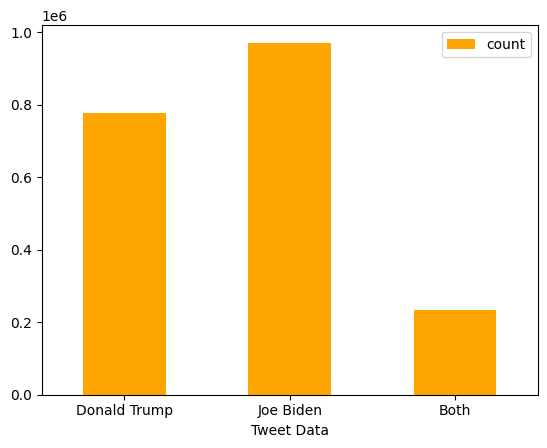

In [292]:
overlap_data = pd.merge(trump_data, biden_data, on = 'tweet', how ='inner')
biden_count= len(biden_data. index)
trump_count = len(trump_data. index)
overlap_count =len(overlap_data. index)
bar_data = pd.DataFrame({"Tweet Data": ["Donald Trump", "Joe Biden", "Both"], "count": [len(biden_data. index), len(trump_data. index),len(overlap_data. index)] })
bar_data.plot.bar(x='Tweet Data', y='count', rot=0, color= 'orange')

 We can see that there is a considerable number of tweets that overlap between the two original data sets. This happens because many tweets contain both hashtags. These tweets can be misleading for our analysis since it is ambiguous as to which party the tweet is about and will also arise duplicated tweets in our concatenated data frame. We will thus delete all the duplicates from our data frame. 

In [293]:
#Dropping all duplicates

df = df.drop_duplicates(subset = 'tweet', keep=False)

In order to get the sentiment scores of each tweets, we must remove hashtags, emojis and mentions within a tweets so that we can conduct our analysis simply on the content of the tweet. 

In [294]:
def clean_tweets(text):
    text = re.sub("@[A-Za-z0-9_]+","", text)
    text = re.sub("#[A-Za-z0-9_]+","", text)
    text = re.sub(r"http\S+", "", text)
    text = re.sub("\n",".",text)
    return text

df['tweet'] = df['tweet'].apply(lambda x: clean_tweets(x))


In [295]:
def remove_emojis(data):
    emoj = re.compile("["
        u"\U0001F600-\U0001F64F"  
        u"\U0001F300-\U0001F5FF"  
        u"\U0001F680-\U0001F6FF"  
        u"\U0001F1E0-\U0001F1FF"  
        u"\U00002500-\U00002BEF"  
        u"\U00002702-\U000027B0"
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        u"\U0001f926-\U0001f937"
        u"\U00010000-\U0010ffff"
        u"\u2640-\u2642" 
        u"\u2600-\u2B55"
        u"\u200d"
        u"\u23cf"
        u"\u23e9"
        u"\u231a"
        u"\ufe0f"  
        u"\u3030"
                      "]+", re.UNICODE)
    return re.sub(emoj, '', data)


df['tweet'] = df['tweet'].apply(remove_emojis)

Now that we have cleaned our tweet data properly, we will calculate the sentiment scores of each tweet. 

In [296]:
df = df.astype({'tweet':'string'})
df['sentiment score'] = df['tweet'].apply(lambda tweet: TextBlob(tweet).sentiment.polarity)

Now we will concatenate our data frame with the election results data frame in order to have the percentage vote counts of each candidate. 

In [297]:
election_results = election_results.loc[(election_results['candidate'] == "Joe Biden") | (election_results['candidate'] == "Donald Trump")]
election_individual_votecount = election_results.groupby(["state", "candidate"]).sum('total_votes')
election_individual_votecount.rename(columns = {'total_votes':'votes_won'}, inplace = True)
election_individual_votecount.reset_index()
df = pd.merge( df, total_vote_data , on = 'state')
df = pd.merge( df, election_individual_votecount, on = ['state', 'candidate'])
df['percent_votes_won'] = df['votes_won']/df['total_votes']*100
df = df.drop(['won'], axis = 1)

#### **Summary Statistics Tables**

In [299]:
df.describe()

,sentiment score,total_votes,votes_won,percent_votes_won
count,167368.000000,1.673680e+05,1.673680e+05,167368.000000
mean,0.051429,7.951040e+06,3.810098e+06,47.756946
std,0.276688,5.439181e+06,2.754574e+06,13.214683
min,-1.000000,2.767650e+05,1.858600e+04,5.397321
25%,0.000000,3.297352e+06,1.661686e+06,37.733937
50%,0.000000,6.925255e+06,3.250230e+06,48.781785
75%,0.150000,1.131791e+07,5.668731e+06,55.400001
max,1.000000,1.749591e+07,1.110976e+07,92.149694


We can see that the mean sentiment score of our data set is 0.05. On average, a tweet is somwhat between neutral and slightly positive. This is good for our research as positive polarity hints towards the inclination of voters toward a candidate. We can see that the standard deviation is 0.27. So, our data has enough variation in building a prediction model. We should also look at the summary of percent_votes_won as it is our Dependent variable. On average, each candidate had 47.75% of votes won, which is quite reasonable given the tough competition that occurred in the states. The standard deviation is quite high in the case of percent_votes_won as there were substantial differences between the vote counts of the candidate in many states. Furthermore, we also had other candidates apart from Joe Biden and Donald Trump who received votes, which might explain the high standard deviation. 

#### **Plots, Histograms, Figures**

Since the fundamental variable for our analysis is the sentiment score of the tweets we can try and look at histogram of the sentiment scores for each candidate respectively. 

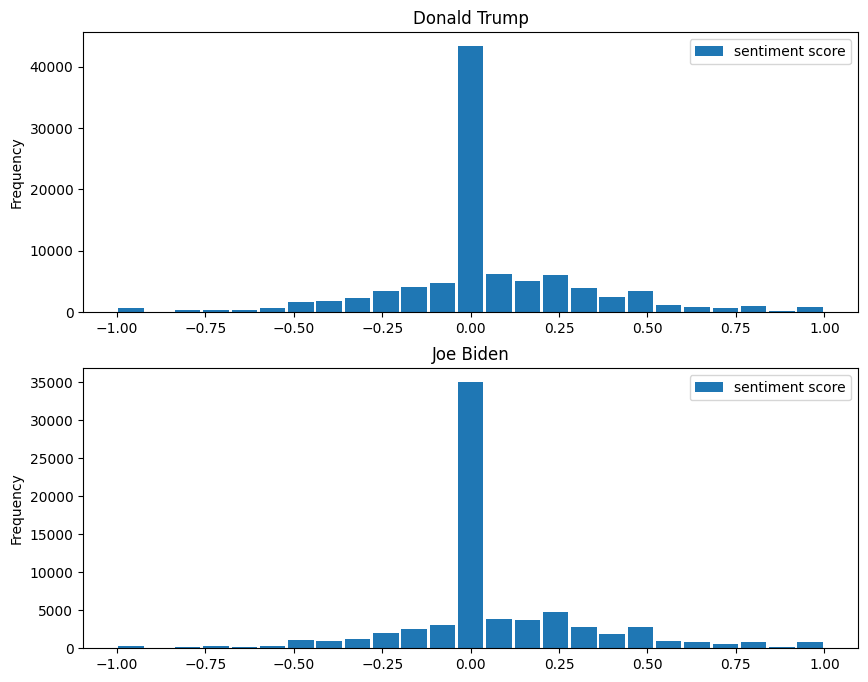

In [312]:
ax = df.plot.hist(column=["sentiment score"], by = "candidate", figsize=(10, 8), bins= 25, zorder=2, rwidth=0.9)

Both the histograms are centered around 0.00. It makes sense to observe a similarity between the distribution of sentiment score of tweets of both the candidtaes, considering the high volume of observations we had. It might be more helpful to look at the difference between the mean sentiment score of the candidates in each state using a bar plot. 

Text(0, 0.5, 'Sentiment Score')

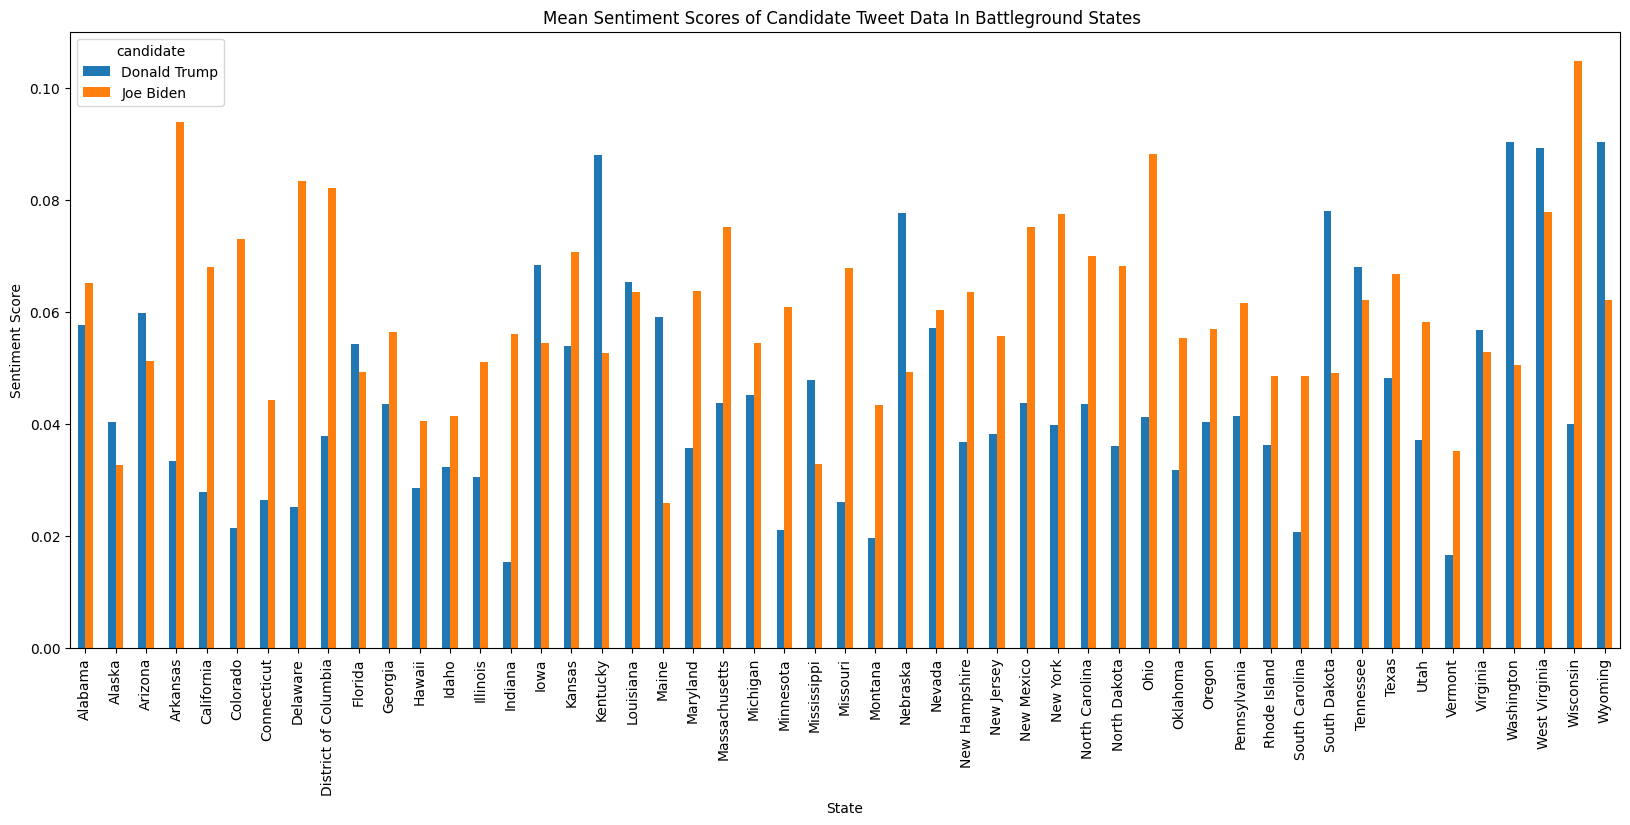

In [309]:
df2 = df.groupby(["state", "candidate"]).mean('sentiment score')
df2 = df2.reset_index()
df2.pivot(index='state', columns = 'candidate', values = 'sentiment score').plot(kind = 'bar', figsize= (20,8), title="test")
plt.title("Mean Sentiment Scores of Candidate Tweet Data In Battleground States ")
plt.xlabel("State")
plt.ylabel("Sentiment Score")

We can see that in the battleground states where Joe Biden won, such as Nevada, Michigan, Minnesota etc., the mean sentiment scores are actually higher than that of Trump's. On the other hand, in states like Massachusetts, Mississippi, Missouri, Iowa, Florida, and Texas, where Trump had the victory, the mean sentiment scores for Trump are higher. This observation is crucial for our analysis as this tells us that we might be able to predict the election outcome using sentiment score. 

We can also plot a scatter plot to look for a correlation between mean sentiment score and vote counts of Canditaes in each state. 

Text(0, 0.5, 'Vote Counts')

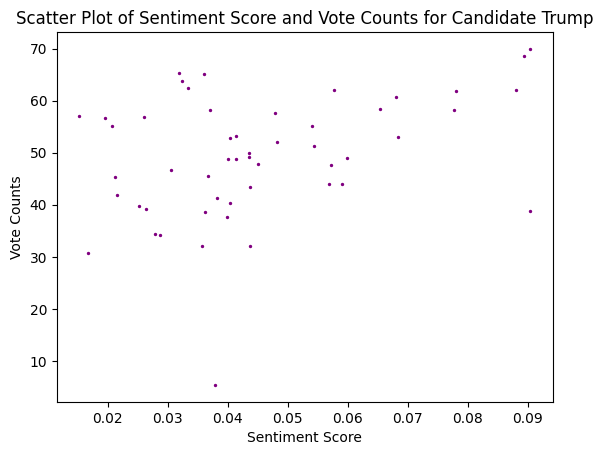

In [310]:
df3 = df.groupby(["state", "candidate"]).mean('sentiment score')
df3 = df3.groupby("candidate")
df4 = df3.get_group('Donald Trump')
plt.scatter(df4['sentiment score'], df4['percent_votes_won'], s=2, c='purple')
plt.title("Scatter Plot of Sentiment Score and Vote Counts for Candidate Trump")
plt.xlabel("Sentiment Score")
plt.ylabel("Vote Counts")


From this plot, we can see that there might be a positive correlation between the mean sentiment score and vote counts of states of the respective candidate. 

#### **Conclusion**

This research assumed a relationship between public sentiments and the election outcome for each state and our analysis has proven it right in the majority of the states. In states like Arizona, North Carolina , Ohio Joe Biden seemed to have a higher mean sentiment score although the winning candidate was Donald Trump due to dominating in the electoral college vote counts.This could be explained better by introducing electoral college vote counts into our data analysis model. 


Lastly, our analysis could be further improved by improving the data cleaning of Tweets so that each tweet could become a better input for Natural Language Processing. Future prospects of this research could be diving further into the tweets data to identify other data cleaning requirements. If all of these factors can be considered, this analysis can be quite promising. 
